In [371]:
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)


Lựa chọn model <br>
Thay models.<Ten_model>

In [372]:
from models.CNNv6 import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [373]:
byte_number = "512"


In [374]:
experiment_name = "GQUIC_" + byte_number
method = "nonFL_CNNv6_W_FS"
client_lr = 3e-4
NUM_ROUNDS = 10
BATCH_SIZE = 32


In [375]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [376]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [377]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [378]:
train_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Train/GQUIC_data_' + byte_number + '.feather'
test_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Test//GQUIC_test_' + byte_number + '.feather'
data = pd.read_feather(train_dir)
test = pd.read_feather(test_dir)


In [379]:
# data.drop(['length'],axis=1,inplace=True)
# test.drop(['length'],axis=1,inplace=True)


In [380]:

result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))


In [381]:
true_test = test.drop('flow_id', axis=1)


In [382]:
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)


512 4


In [383]:
y_test = true_test['Label'].to_numpy()
x_test = true_test.drop('Label', axis=1).to_numpy()
y_train = data['Label'].to_numpy()
x_train = data.drop(['Label'], axis=1).to_numpy()

In [384]:
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data,
#                       columns=sklearn_dataset.feature_names)
#     df['Label'] = pd.Series(sklearn_dataset.Label)
#     return df


In [385]:
# from sklearn import datasets
# df = sklearn_to_df(datasets.load_iris())


In [386]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [388]:
model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 512, 32)           832       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 171, 32)          0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 5472)              0         
                                                                 
 dense_23 (Dense)            (None, 32)                175136    
                                                                 
 dense_24 (Dense)            (None, 4)                 132       
                                                                 
Total params: 176,100
Trainable params: 176,100
Non-trainable params: 0
_______________________________________________

In [ ]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 0 hours 4 mins 56 seconds


### Evaluation

In [ ]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]

In [ ]:
_, test_acc = model.evaluate(x_test, y_test,verbose=2, batch_size=BATCH_SIZE,use_multiprocessing=True)

1738/1738 - 3s - loss: 12.9052 - sparse_categorical_accuracy: 0.2312 - 3s/epoch - 2ms/step


In [ ]:
train_val = str(round(best_model_accuracy*100)) + "_" + str(round(test_acc*100))

In [ ]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [ ]:
model.save(model_dir/'model.h5')

In [ ]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [ ]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [ ]:
predictions = model.predict(x_test,verbose=2,use_multiprocessing=True,batch_size=BATCH_SIZE)

1738/1738 - 3s - 3s/epoch - 2ms/step


In [ ]:
y_pred = np.argmax(predictions, axis=-1)
test['pred'] = y_pred.tolist()

In [ ]:
result = test.groupby('flow_id')['pred'].apply(list).to_dict()
flow_pred = []
for flow in result:
    flow_pred.append(most_frequent(result[flow]))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_class

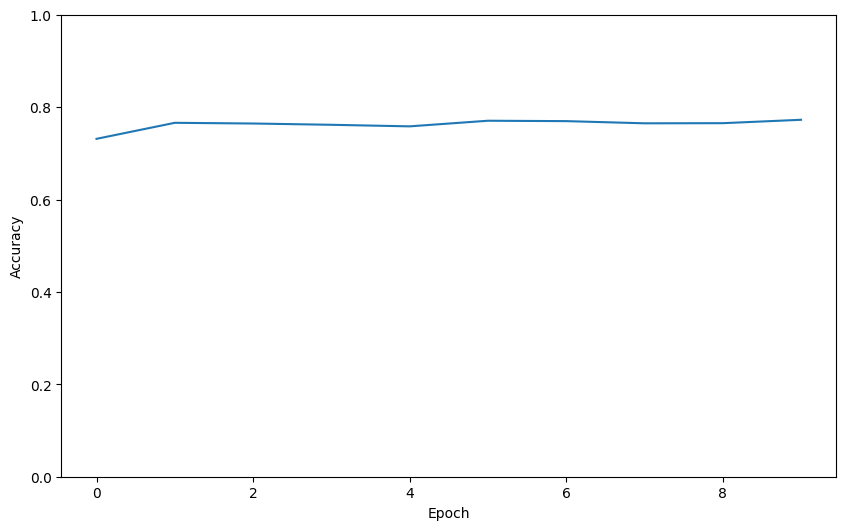

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.savefig(output_dir / "normal_model_Accuracy.png")